In [2]:
# Import packages
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime
import math

plt.rcParams['figure.figsize'] = [11, 8]

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
!pip install mpld3
import mpld3
!pip install html2text
import html2text

     |████████████████████████████████| 890kB 9.3MB/s 
  Created wheel for mpld3: filename=mpld3-0.5.2-cp36-none-any.whl size=200618 sha256=9a9d47735ee2d6cf91ff94ac9eaf23e5b81076b44a56a5ee1f27079ce19ecbec
  Stored in directory: /root/.cache/pip/wheels/21/73/06/ea4b85609301850b1289a282852d92e22fcbf7a250ed5f547f
Successfully built mpld3


In [148]:
ks_file = '/content/drive/MyDrive/Colab Notebooks/DSI_kickstarterscrape_dataset.csv'
ks = pd.read_csv(ks_file,encoding = "ISO-8859-1",parse_dates=['funded date'])

In [149]:
ks = ks.dropna(subset=['pledged'])
print('Mean pledge per project ${}'.format(int(ks.pledged.mean())))


Mean pledge per project $4980


In [156]:
ks= ks.rename(columns={'funded date': 'launched'})
ks = ks.dropna(subset=['pledged'])
ks = ks.loc[ks['status'].isin(['successful','failed'])]

ks = ks.drop(columns=['project id', 'url','subcategory','location','reward levels'])


In [157]:
for c in ['name','category']:
  ks[c] = ks[c].apply(lambda s: html2text.html2text(s).rstrip())


In [158]:
ks["status"] = ks["status"].replace({'failed':0, 'successful':1})

ks = ks.assign(hour=ks.launched.dt.hour,
               doy =ks.launched.dt.dayofyear,
               day=ks.launched.dt.weekday,
               weekend = ks.launched.dt.weekday.apply(lambda x: 1 if x > 4 else 0),
               month=ks.launched.dt.month,
               year=ks.launched.dt.year,
               name_length = ks.name.apply(lambda s: len(s.replace(" ","")))
               )
ks['fraction_goal']= ks.pledged/ks.goal

In [159]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2008-01-01', end='2012-12-31').to_pydatetime()
def is_holidays(d):
  date=datetime.datetime(d.year,d.month,d.day)
  if date in holidays: return 1
  else: return 0 
ks['holidays']=ks.launched.apply(is_holidays)

In [160]:
print('number of projects',len(ks.index))
print('success rate',len(ks[ks.status==1].index)/len(ks.index))
print(len(ks.category.unique()),'different categories')


number of projects 41965
success rate 0.5473370666031216
13 different categories


In [161]:
print('Mean pledge per project ${}'.format(int(ks.pledged.mean())))

Mean pledge per project $5123


In [ ]:
def succ_frac(df):
  all = len(df.index)
  succ = len(df[df.status==1].index)
  if all != 0: frac=succ/all
  if all==0: frac =1e-10
  return frac

### Category

In [10]:
cats = pd.concat([ks.category.value_counts().to_frame(),ks[ks.status==1].category.value_counts().to_frame().rename(columns={'category': 'funded'})],axis=1)
cats['fraction'] = cats.funded/cats.category
cats.sort_values('fraction')

,category,funded,fraction
Fashion,1019,335,0.328754
Technology,737,289,0.392130
Publishing,4155,1671,0.402166
Games,1467,635,0.432856
Photography,1387,645,0.465032
Design,1566,729,0.465517
Food,1298,655,0.504622
Film & Video,12595,6423,0.509964
Comics,968,520,0.537190
Art,3691,2106,0.570577


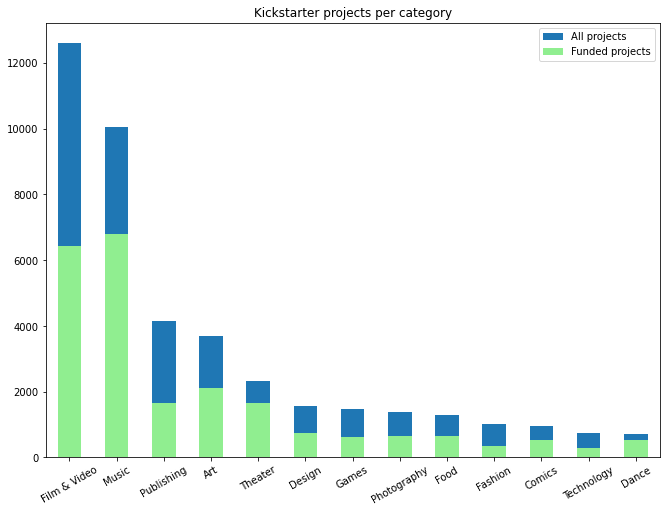

In [11]:
_, ax = plt.subplots()
cats.category.plot(kind='bar', ax=ax,label='All projects')
cats.funded.plot(kind='bar', ax=ax,color='lightgreen',label='Funded projects')
plt.title('Kickstarter projects per category')
plt.legend()
plt.xticks(rotation=30)

plt.show()

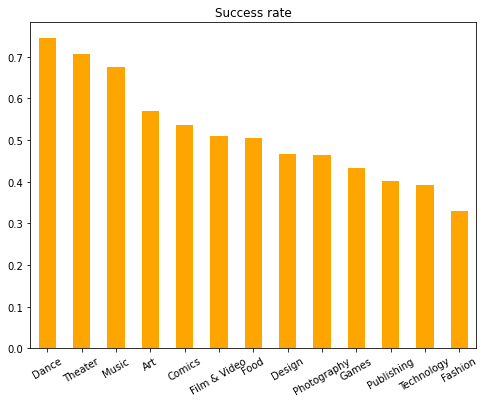

In [62]:
fig, ax = plt.subplots(figsize=(8,6))
cats.fraction.sort_values(ascending=False).plot(kind='bar',color='orange',label='Success fraction')
plt.title('Success rate')
plt.xticks(rotation=30)
plt.show()



In [64]:
n,P=500,0.75
std = math.sqrt( n * P * ( 1 - P ) )
print(std)
#error on the average P based n trials is std / n

9.682458365518542


### Duration

In [56]:
bins=np.linspace(0,90,4)+0.1
bins

array([ 0.1, 30.1, 60.1, 90.1])

In [57]:
frac = []
for i in range(len(bins)-1):
  all = len(ks[(ks.duration>bins[i])&(ks.duration<=bins[i+1])].index)
  suc = len(ks[(ks.duration>bins[i])&(ks.duration<=bins[i+1])&(ks.status==1)].index)
  frac.append(suc/all)
  print(bins[i],bins[i+1],suc/all,all)

0.1 30.1 0.5827785895978784 18477
30.1 60.1 0.5346560164905952 19405
60.1 90.1 0.4566160520607375 3688


In [54]:
bins=np.linspace(0,90,7)+0.1
frac = []
for i in range(len(bins)-1):
  all = len(ks[(ks.duration>bins[i])&(ks.duration<=bins[i+1])].index)
  suc = len(ks[(ks.duration>bins[i])&(ks.duration<=bins[i+1])&(ks.status==1)].index)
  frac.append(suc/all)
  print(bins[i],bins[i+1],suc/all,all)

0.1 15.1 0.6616586538461539 1664
15.1 30.1 0.5749717480521025 16813
30.1 45.1 0.5846689895470383 11480
45.1 60.1 0.4622082018927445 7925
60.1 75.1 0.5165562913907285 1661
75.1 90.1 0.407498766650222 2027


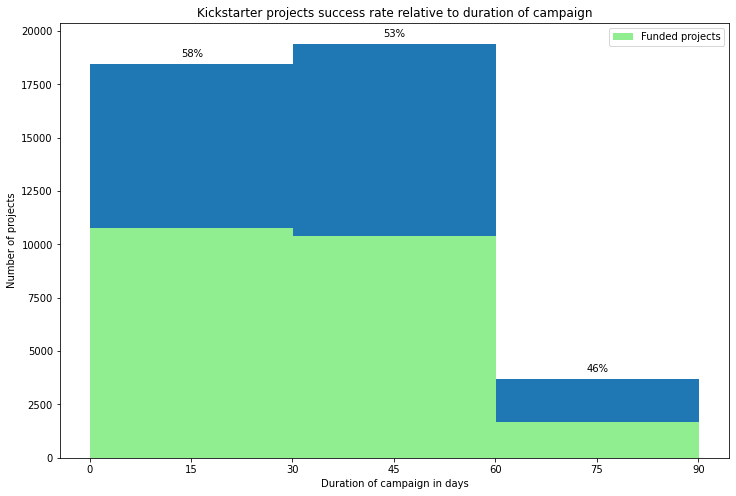

In [58]:
#bins=30

fig, ax = plt.subplots(figsize=(12,8))

ax.hist(ks.duration,bins=bins)

for i,rect in enumerate(ax.patches):
    height = rect.get_height()
    ax.annotate('{:.0f}%'.format(frac[i]*100), xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom') 
    

plt.hist(ks[ks.status==1].duration,bins=bins,color='lightgreen',label='Funded projects')
plt.xticks(np.linspace(0,90,7))
plt.legend()
plt.title('Kickstarter projects success rate relative to duration of campaign')
plt.xlabel('Duration of campaign in days')
plt.ylabel('Number of projects')
plt.show()

### Goal

In [ ]:
ks[ks.status==1].sort_values('goal',ascending=False).head(10)

In [108]:
frac_=[]
b_ = np.logspace(1,7,20)
for i in range(len(b_)-1):
  print(b_[i],succ_frac(ks[(ks.goal>b_[i])&(ks.goal<=b_[i+1])]))
  frac_.append(succ_frac(ks[(ks.goal>b_[i])&(ks.goal<=b_[i+1])]))


10.0 0.8823529411764706
20.6913808111479 0.8285714285714286
42.81332398719393 0.8253968253968254
88.58667904100822 0.6782608695652174
183.29807108324357 0.7146042363433668
379.26901907322497 0.7093297406534187
784.7599703514607 0.6675274370561652
1623.776739188721 0.6332077195386548
3359.818286283781 0.5421925524147283
6951.927961775606 0.46222095020034343
14384.498882876629 0.34900176901693203
29763.51441631313 0.23158593231585933
61584.82110660255 0.14767932489451477
127427.49857031321 0.06
263665.08987303555 0.09230769230769231
545559.4781168514 0.07692307692307693
1128837.8916846884 0.0
2335721.4690901213 0.0
4832930.238571752 1e-10


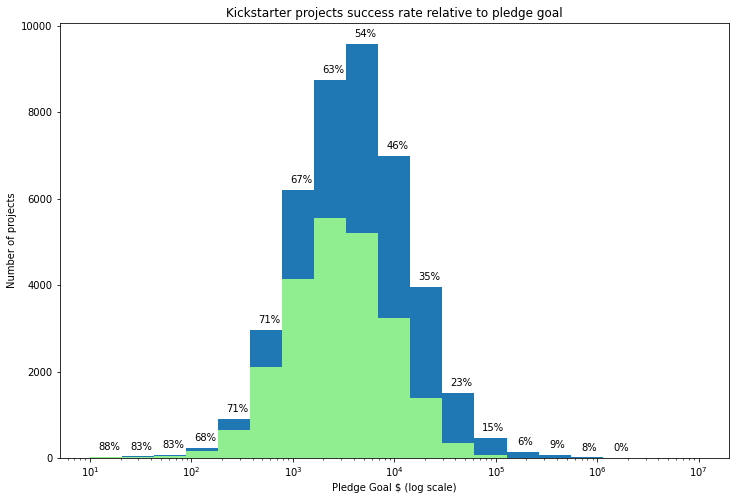

In [109]:

fig, ax = plt.subplots(figsize=(12,8))

ax.hist(ks.goal,bins=b_)

for i,rect in enumerate(ax.patches[:-2]):
    height = rect.get_height()
    ax.annotate('{:.0f}%'.format(frac_[i]*100), xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom') 


plt.hist(ks[ks.status==1].goal,bins=b_,color='lightgreen',label='Funded projects')
plt.xscale('log')
plt.xlabel('Pledge Goal $ (log scale)')
plt.ylabel('Number of projects')
plt.title('Kickstarter projects success rate relative to pledge goal')
plt.show()

## Month, day, hours

In [120]:
succ_frac(ks)

0.5473370666031216

In [162]:
ks.groupby(ks.doy).sum()

,status,goal,pledged,funded percentage,backers,levels,updates,comments,duration,p,hour,day,weekend,month,year,name_length,fraction_goal,holidays
doy,,,,,,,,,,,,,,,,,,
1,174,2960249.00,1616925.0,281.239408,19980,2489,1362,1722,13564.94,313,2548,1709,284,313,629587,9875,281.239159,29
2,73,1794146.11,639998.0,99.811631,7755,1172,668,669,5953.05,133,1313,270,46,133,267544,4191,99.804778,87
3,62,1132991.24,919392.0,99.938751,9138,834,488,591,4558.89,100,1090,93,5,100,201158,3107,99.938928,0
4,44,484362.00,261854.0,62.555996,3651,661,312,221,3576.10,86,874,139,0,86,172999,2628,62.556205,0
5,55,521205.47,274061.0,73.858623,3649,689,306,344,3668.75,93,1006,230,0,93,187067,2890,73.868285,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,32,1001995.00,351510.0,44.498308,3845,578,310,670,3453.88,72,985,64,2,864,144770,2203,44.498897,0
362,15,554650.00,93318.0,21.639693,1267,372,120,80,2125.46,50,672,84,0,600,100534,1528,21.639440,0
363,34,643140.00,256019.0,61.811099,3259,612,274,249,3581.62,84,899,224,0,1008,168896,2621,61.811447,0


In [ ]:
ks['p']=1
df=ks.groupby(ks.month).sum()
df['fraction'] = df.status/df.p
df
df.fraction.plot(kind='bar')

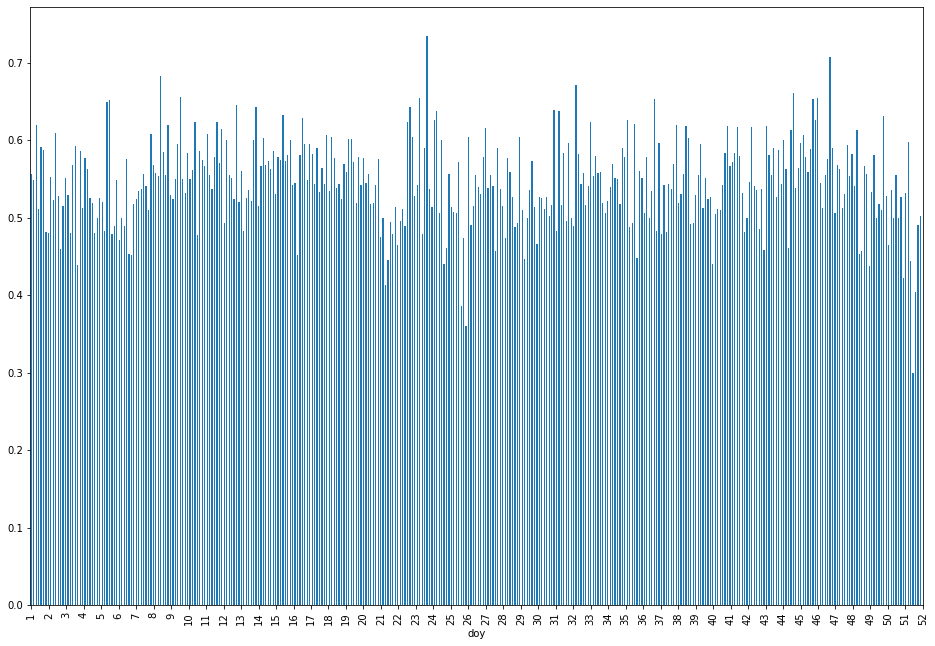

In [163]:
fig, ax = plt.subplots(figsize=(16,11))

ks['p']=1
df=ks.groupby(ks.doy).sum()
df['fraction'] = df.status/df.p
df

df.fraction.plot(kind='bar')

plt.xticks(np.linspace(0,365,52))
plt.show()

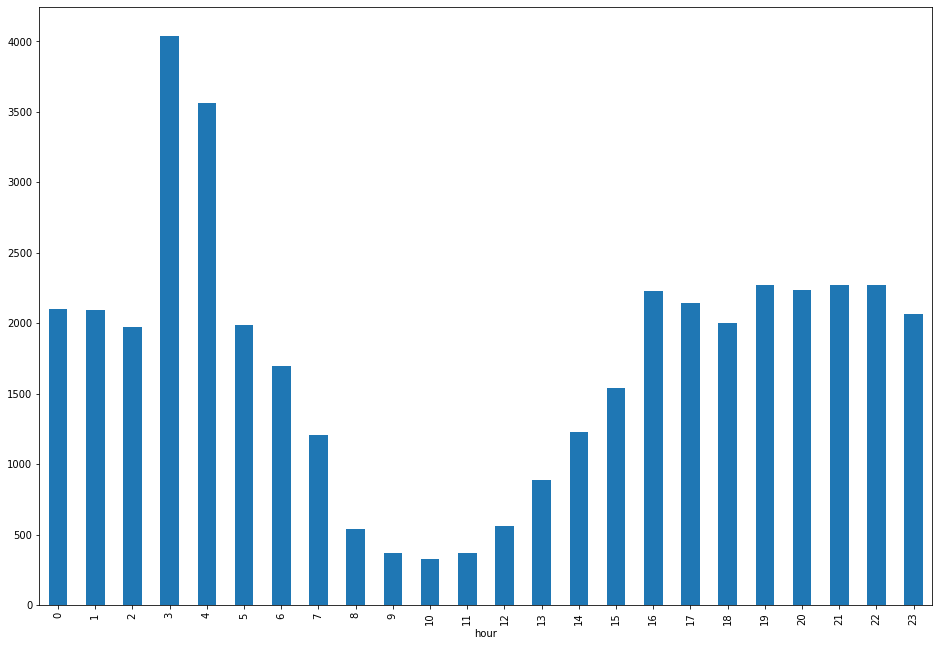

In [165]:
fig, ax = plt.subplots(figsize=(16,11))

ks['p']=1
df=ks.groupby(ks.hour).sum()
df['fraction'] = df.status/df.p
df

df.p.plot(kind='bar')

plt.show()

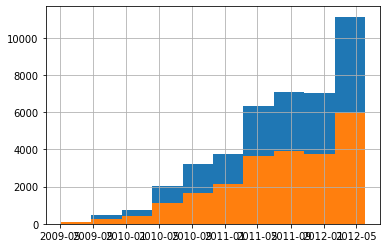

In [9]:
ks.launched.hist()
ks[ks.status==1].launched.hist()
plt.show()

In [ ]:
ks['p']=1
df=ks.groupby([(ks.year),(ks.month)]).sum()
df['fraction'] = df.status/df.p
df

In [133]:
ks.launched.iloc[0]

Timestamp('2011-08-19 19:28:17+0000', tz='UTC')

In [140]:
succ_frac(ks[ks.holidays==1])

0.5387323943661971

In [142]:
ks[ks.holidays==1]

,name,category,status,goal,pledged,funded percentage,backers,launched,levels,updates,comments,duration,hour,doy,day,weekend,month,year,name_length,fraction_goal,p,holidays
22,Release Sxip Shirey's SONIC NEW YORK,Music,1,5000.0,6860.0,1.372000,110,2009-11-26 18:38:00+00:00,14,28,9,88.19,18,330,3,0,11,2009,31,1.372000,1,1
25,Crossroads [San Francisco Cinematheque],Film & Video,1,7000.0,7030.0,1.004286,41,2010-10-11 06:59:00+00:00,6,0,0,37.34,6,284,0,0,10,2010,36,1.004286,1,1
30,"""Rainy Day"" a sci fi drama feature film",Film & Video,0,15000.0,1.0,0.000067,1,2011-07-04 22:09:40+00:00,1,1,0,60.00,22,185,0,0,7,2011,32,0.000067,1,1
42,""" Hugo's There "" \- Real News. Unbelievably.",Film & Video,0,8400.0,25.0,0.002976,1,2011-09-05 01:20:25+00:00,9,1,0,42.00,1,248,0,0,9,2011,37,0.002976,1,1
52,Remnants: Finishing Phase,Film & Video,1,8000.0,10544.0,1.318000,131,2011-05-30 03:59:43+00:00,5,23,36,45.00,3,150,0,0,5,2011,23,1.318000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45891,Zee.Dog - Stirring things up in the Dog Industry,Design,1,10000.0,10805.0,1.080500,84,2010-11-25 00:12:56+00:00,7,9,4,45.04,0,329,3,0,11,2010,40,1.080500,1,1
45892,Zee.Dog - Stirring things up in the Dog Industry,Design,1,10000.0,10805.0,1.080500,84,2010-11-25 00:12:56+00:00,7,9,4,45.04,0,329,3,0,11,2010,40,1.080500,1,1
45899,Foreigners Living In America,Film & Video,0,150000.0,100.0,0.000667,1,2012-01-02 18:38:00+00:00,10,0,1,50.94,18,2,0,0,1,2012,25,0.000667,1,1
45900,Foreigners Living In America,Film & Video,0,150000.0,100.0,0.000667,1,2012-01-02 18:38:00+00:00,10,0,1,50.94,18,2,0,0,1,2012,25,0.000667,1,1


In [153]:
bins = np.logspace(0,5,40)
plt.hist(ks.backers,bins=bins)
#plt.xscale('log')
mpld3.display()


In [154]:
from scipy.stats import skew,kurtosis
skew(ks.backers)

87.88721924727078

# ML modeling

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ks_cat = ks[['category']]
## one-hot encoding
cat_cols=['category']
enconding = OneHotEncoder(handle_unknown='ignore', sparse=False)
enconding.fit(ks_cat)
ks_cat_enc = pd.DataFrame(enconding.transform(ks_cat))

## add back column names
ks_cat_enc.columns = enconding.get_feature_names(cat_cols)

In [ ]:
ks = ks.reset_index().drop(columns=['index'])


In [ ]:
ks = pd.concat([ks, ks_cat_enc], axis=1)

In [ ]:
ks = ks.drop(columns=['name','category','funded percentage','launched','month','weekend'])

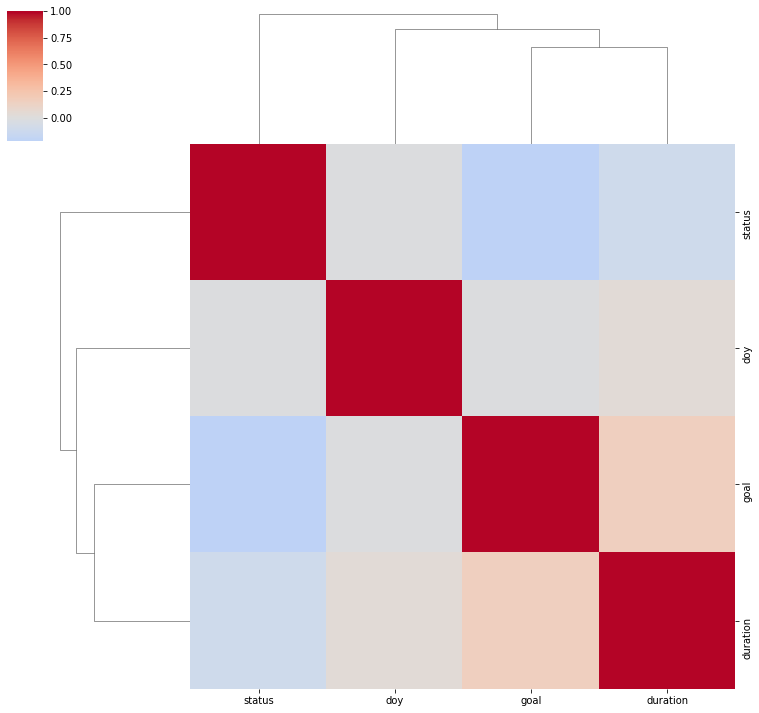

In [ ]:
# calculate kendall correlations
corrs = ks[['status','goal','duration','doy']].corr(method='kendall')

# clustered heatmap
sns.clustermap(corrs, cmap='coolwarm', center=0, figsize=(10,10), cbar_pos=(-0.05, 0.8, 0.05, 0.18));

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## define predictors and label 
label = ks.status
features = [c for c in ks.columns if c not in ["status"]]

## prepare training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(ks[features], label, test_size = 0.2, random_state = 2)

## train a random forest classifier 
model = RandomForestClassifier(n_estimators=50, random_state=0).fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
# View accuracy score
accuracy_score(y_test, y_pred)

0.9998808530918623

In [ ]:
# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred)

array([[3805,    1],
       [   0, 4587]])

In [ ]:
# evaluate nlp
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3806
           1       1.00      1.00      1.00      4587

    accuracy                           1.00      8393
   macro avg       1.00      1.00      1.00      8393
weighted avg       1.00      1.00      1.00      8393



In [ ]:
model.predict?

In [ ]:
features

['goal',
 'pledged',
 'backers',
 'levels',
 'updates',
 'comments',
 'duration',
 'hour',
 'doy',
 'day',
 'year',
 'name_length',
 'fraction_goal',
 'category_Art',
 'category_Comics',
 'category_Dance',
 'category_Design',
 'category_Fashion',
 'category_Film & Video',
 'category_Food',
 'category_Games',
 'category_Music',
 'category_Photography',
 'category_Publishing',
 'category_Technology',
 'category_Theater']